In [15]:
# Imports
import sys
sys.path.append('..')
from swdf.benchmark import *
from tsai.basics import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from swdf.utils import *
import wandb
from swdf.losses import *
from swdf.plots import *
wandb_api = wandb.Api()

# Evaluation of Solar FSMY 10.7 Ensemble Forecaster

In this notebook, we evaluate the performance of the trained model in comparison to the benchmark established by [Licata et al. (2020)](https://doi.org/10.1029/2020sw002496). 


In [16]:
# Constants
# ARTIFACT_DOWNLOAD_PATH = Path(os.environ["WANDB_DIR"])/"wandb/artifacts/solfsmy_eval_tmp"

In [17]:
# Config
config = yaml2dict('config/solfsmy_ensemble.yaml')

config

```json
{ 'data': { 'add_time_channels': False,
            'data_columns': ['F10', 'S10', 'M10', 'Y10'],
            'data_nb': './solfsmy_data.ipynb',
            'data_path': '../data/SOLFSMY.TXT',
            'data_time_columns': ['Year', 'DDD'],
            'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
            'df_save_path': './preprocessed_data/dataframes/solfsmy.pkl',
            'exp_pipe_save_path': './preprocessed_data/pipelines/exp_solfsmy.pkl',
            'force_download': False,
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_solfsmy.pkl'},
  'eval': { 'dst_data_path': '../data/DST_IAGA2002.txt',
            'learner_artifact': None,
            'round_preds': True,
            'solfsmy_data_path': '../data/SOLFSMY.TXT'},
  'train': { 'bs': 32,
             'horizon': 6,
             'learner1': { 'arch_config_file': 'config/patchtst.yaml',
                           'arch_name': 'PatchTST',
                           'init_weights': False,
                           'loss_config': {},
                           'loss_func': 'wMSE',
                           'lr_max': None},
             'learner2': { 'arch_config_file': 'config/patchtst.yaml',
                           'arch_name': 'PatchTST',
                           'init_weights': False,
                           'loss_config': {},
                           'loss_func': 'wMAE',
                           'lr_max': None},
             'lookback': 24,
             'main_metric': 'default',
             'metrics_handler_path': None,
             'n_epoch': 30,
             'partial_n': 0.1}}
```

In [18]:
learner1 = load_learner_all("tmp", model_fname = 'model_learner1', learner_fname="learner_learner1", 
                         verbose=True, 
                         device=default_device())

learner2 = load_learner_all("tmp", model_fname = 'model_learner2', learner_fname="learner_learner2", 
                         verbose=True, 
                         device=default_device())

Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner1.pth'
learner_fname = 'learner_learner1.pkl'
Learner loaded:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_learner2.pth'
learner_fname = 'learner_learner2.pkl'


In [19]:
y_test_preds_learner1, y_test = learner1.get_preds(ds_idx = 2, with_targs=True)
y_test_preds_learner2, _ = learner2.get_preds(ds_idx = 2, with_targs=True) 

y_test_preds = (y_test_preds_learner1 + y_test_preds_learner2) / 2

y_test_preds = to_np(y_test_preds)
y_test = to_np(y_test)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (2254, 4, 6)


In [20]:
horizon = y_test.shape[-1]
data_columns_fcst = ['F10', 'S10', 'M10', 'Y10']

The evaluation is done for each variable separately, for each solar activity 
level (low, moderate, elevated and high), as in the paper by Licata et al. (2020)
Therefore, the test set has to be split into 4 different sets, one for each solar activity level. The thresholds for each solar activity level are the same as in the paper by Licata et al. (2020)

The thresholds are:
- F10: 75, 150, 190
- S10: 65, 150, 215
- M10: 72, 144, 167
- Y10: 81, 148, 165

In [21]:
#|export

def get_idxs_per_solar_activity_level(data, thresholds):
    # function that splits the data of a variable into 4 different sets, 
    # one for each solar activity level. The data comes as a numpy array with 
    # shape (samples, steps), and the split is done along the samples axis. 
    # The decision is made based on the first column of each sample. The function 
    # returns a list of 4 numpy arrays, one for each solar activity level. 
    # But it does not return the values, it returns the indices of the
    # samples that belong to each solar activity level.
    idxs_per_solar_activity_level = []
    for i in range(len(thresholds) + 1):
        if i == 0:
            idxs = np.where(data[:, 0] <= thresholds[i])[0]
        elif i == len(thresholds):
            idxs = np.where(data[:, 0] > thresholds[i-1])[0]
        else:
            idxs = np.where((data[:, 0] > thresholds[i-1]) & (data[:, 0] <= thresholds[i]))[0]
        idxs_per_solar_activity_level.append(idxs)
    return idxs_per_solar_activity_level

In [22]:
# Call the function for each variable, using y_test
thresholds = {'F10': [75, 150, 190], 
              'S10': [65, 150, 215], 
              'M10': [72, 144, 167], 
              'Y10': [81, 148, 165]}

y_test_split_idxs = {}
for i, var in enumerate(data_columns_fcst):
    y_test_split_idxs[var] = get_idxs_per_solar_activity_level(y_test[:, i, :], 
                                                               thresholds[var])
# Check the shape of each variable
for var in data_columns_fcst:
    print(f"{var}: {[y_test_split_idxs[var][i].shape for i in range(4)]}")

F10: [(591,), (1435,), (205,), (23,)]
S10: [(496,), (1475,), (283,), (0,)]
M10: [(529,), (1477,), (223,), (25,)]
Y10: [(487,), (1666,), (97,), (4,)]


In [23]:
df_SET = pd.read_pickle('preprocessed_data/dataframes/set_solfsmy.pkl')

_, y_test_SET = SlidingWindow(
            window_len=config.train.lookback,
            horizon=config.train.horizon, 
            stride=1, 
            get_x=['S10'], 
            get_y=['S10']
        )(df_SET)

y_test_split_idxs['S10'] = get_idxs_per_solar_activity_level(y_test_SET, thresholds['S10'])

# Check the shape of each variable
for var in data_columns_fcst:
    print(f"{var}: {[y_test_split_idxs[var][i].shape for i in range(4)]}")

F10: [(591,), (1435,), (205,), (23,)]
S10: [(520,), (1433,), (267,), (33,)]
M10: [(529,), (1477,), (223,), (25,)]
Y10: [(487,), (1666,), (97,), (4,)]


In [24]:
# Now split y_test and y_test_preds with the idxs we got, using numpy.take
y_test_split = {}
y_test_preds_split = {}
for var in data_columns_fcst:
    y_test_split[var] = [y_test[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]
    y_test_preds_split[var] = [y_test_preds[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]

# Check the shape of each variable in y_test_split
for var in data_columns_fcst:
    print(f"y_test-{var}: {[y_test_split[var][i].shape for i in range(4)]}")
    print(f"y_test_preds-{var}: {[y_test_preds_split[var][i].shape for i in range(4)]}")

y_test-F10: [(591, 6), (1435, 6), (205, 6), (23, 6)]
y_test_preds-F10: [(591, 6), (1435, 6), (205, 6), (23, 6)]
y_test-S10: [(520, 6), (1433, 6), (267, 6), (33, 6)]
y_test_preds-S10: [(520, 6), (1433, 6), (267, 6), (33, 6)]
y_test-M10: [(529, 6), (1477, 6), (223, 6), (25, 6)]
y_test_preds-M10: [(529, 6), (1477, 6), (223, 6), (25, 6)]
y_test-Y10: [(487, 6), (1666, 6), (97, 6), (4, 6)]
y_test_preds-Y10: [(487, 6), (1666, 6), (97, 6), (4, 6)]


In [25]:
# Create a table (dataframe) with the mean forecast error for each variable (F10, S10, M10, Y10), 
# each solar activity level and each horizon (1..horizon)
data = []
sals = ['low', 'moderate', 'elevated', 'high']
for var_idx, var in enumerate(data_columns_fcst):
    for sal_idx,sal in enumerate(sals):
        for h in range(1, horizon+1):
            fe_sfu = forecast_error(y_test_split[var][sal_idx], 
                                y_test_preds_split[var][sal_idx], h)
            fe_percent = percent_forecast_error(y_test_split[var][sal_idx],
                                            y_test_preds_split[var][sal_idx], h)
            n_samples = y_test_split[var][sal_idx].shape[0]
            data.append([var, sal, h, np.mean(fe_sfu), np.std(fe_sfu), 
                        np.mean(fe_percent), np.std(fe_percent), n_samples])
df_results = pd.DataFrame(data, columns=['variable', 'condition', 'horizon', 
                                         'mean_sfu', 'std_sfu', 'mean_percent', 
                                         'std_percent', 'n_samples'])
df_results.head(10)

,variable,condition,horizon,mean_sfu,std_sfu,mean_percent,std_percent,n_samples
0,F10,low,1,0.253184,1.289272,0.360529,1.805295,591
1,F10,low,2,0.239555,1.695057,0.357883,2.349162,591
2,F10,low,3,0.176534,2.183134,0.298104,2.987945,591
3,F10,low,4,0.416489,2.711614,0.659994,3.656886,591
4,F10,low,5,0.225710,3.217510,0.440518,4.245781,591
5,F10,low,6,0.422187,3.735219,0.751909,4.827784,591
6,F10,moderate,1,-0.091003,2.809239,-0.060214,2.383655,1435
7,F10,moderate,2,-0.434075,4.415401,-0.288741,3.673837,1435
8,F10,moderate,3,-1.078974,5.989987,-0.741014,4.954376,1435
9,F10,moderate,4,-0.973813,7.136340,-0.539141,5.889838,1435


In [26]:
# Divide the table into one dataframe for each variable, and print it in a way
# that has the same format as the table in the paper, that is:
# Columns: | Condition | Statistics | 1 Day | 2 Days | 3 Days | ... | {{horizon}} Days,
# where condition is the variable and the solar activity level, and statistics 
# is the mean (column mean_fe) and the standard deviation (std_fe) of the forecast error.
for i, var in enumerate(data_columns_fcst):
    df_var = df_results[df_results['variable'] == var]

    df_var = df_var.melt(id_vars=['condition', 'horizon'], 
                         value_vars=['mean_sfu', 'std_sfu'], 
                         var_name='Statistic')
    # Sort the values of the column condition so that the order is 
    # low, moderate, elevated, high
    df_var['condition'] = pd.Categorical(df_var['condition'], 
                                      categories=['low', 'moderate', 'elevated', 'high'], 
                                      ordered=True)
    df_var = df_var.pivot_table(index=['condition', 'Statistic'], 
                          columns='horizon', 
                          values='value')
    # pretty print, and separate with a blank line
    print(f'Distribution Statistics {var} Error Distribution \n{df_var.to_string()}\n')

Distribution Statistics F10 Error Distribution 
horizon                     1         2         3          4          5          6
condition Statistic                                                               
low       mean_sfu   0.253184  0.239555  0.176534   0.416489   0.225710   0.422187
          std_sfu    1.289272  1.695057  2.183134   2.711614   3.217510   3.735219
moderate  mean_sfu  -0.091003 -0.434075 -1.078974  -0.973813  -1.596152  -1.461858
          std_sfu    2.809239  4.415401  5.989987   7.136340   8.511149   9.629210
elevated  mean_sfu  -0.759718 -1.795084 -2.488440  -2.422431  -2.204080  -1.353076
          std_sfu    3.806529  6.381474  8.684984  10.708257  11.982726  12.614729
high      mean_sfu  -1.732162 -3.790969 -4.990752  -5.466260  -5.042551  -2.983141
          std_sfu    3.330431  4.966432  5.670048   6.672052   8.560189  10.103167

Distribution Statistics S10 Error Distribution 
horizon                     1         2         3          4          5  

In [27]:
# Convert df_results into long format
df_results_lf = df_results.melt(id_vars=['variable', 'condition', 'horizon'],
                                value_vars=['mean_sfu', 'std_sfu', 'mean_percent', 'std_percent'],
                                var_name='statistic')

# Filter out the percent statistics
df_results_lf = df_results_lf[df_results_lf['statistic'].str.contains('percent') == False]

# Rename the Statistic 'mean_sfu' to just 'mean' and 'std_sfu' to 'std'
df_results_lf['statistic'] = df_results_lf['statistic'].str.replace('_sfu', '')

df_results_lf.head()

,variable,condition,horizon,statistic,value
0,F10,low,1,mean,0.253184
1,F10,low,2,mean,0.239555
2,F10,low,3,mean,0.176534
3,F10,low,4,mean,0.416489
4,F10,low,5,mean,0.225710


In [28]:
# Compare these results with the results in the paper. The results in the paper
# can be found in the data folder as a csv
df_results_paper = pd.read_csv('../data/paper_results.csv')

# Filter out the rows with Statistics = 'EBM'
df_results_paper = df_results_paper[df_results_paper['statistic'] != 'EBM']

# Rename the values of the column condition to the ones of the sals variable
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Low solar', 'low')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Moderate solar', 'moderate')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('Elevated solar', 'elevated')
df_results_paper['condition'] = df_results_paper['condition'].str.replace('High solar', 'high')

df_results_paper.head()

,variable,condition,statistic,1 Days,2 Days,3 Days,4 Days,5 Days,6 Days
0,F10,low,mean,-0.2685,-0.7472,-0.6672,-0.3721,-0.0674,0.2428
1,F10,low,std,3.6985,4.7031,5.5001,6.1683,6.7677,7.2050
3,F10,moderate,mean,-0.8251,-0.8095,-0.9639,-1.1450,-1.1456,-1.1679
4,F10,moderate,std,12.0854,14.9853,17.8425,20.2973,21.9353,23.3389
6,F10,elevated,mean,5.7270,7.2425,9.0385,10.3829,11.0017,10.9559


In [29]:
# Convert df_results_paper into long format
df_results_paper_lf = df_results_paper.melt(id_vars=['variable', 'condition', 'statistic'],
                                            value_vars=[f'{i} Days' for i in range(1, horizon+1)],
                                            var_name='horizon', value_name='value')

# Convert the value sof the horizon column to int
df_results_paper_lf['horizon'] = df_results_paper_lf['horizon'].str.replace(' Days', '').astype(int)
df_results_paper_lf.head()

,variable,condition,statistic,horizon,value
0,F10,low,mean,1,-0.2685
1,F10,low,std,1,3.6985
2,F10,moderate,mean,1,-0.8251
3,F10,moderate,std,1,12.0854
4,F10,elevated,mean,1,5.7270


In [30]:
# Join the two dataframes (df_results_ours and df_results_paper) on the columns 
# variable, condition and Statistic
df_results_joined = df_results_lf.merge(df_results_paper_lf, how='left', 
                                            on=['variable', 'condition', 'statistic', 'horizon'],
                                            suffixes=('_ours', '_paper'))
len(df_results_lf), len(df_results_paper_lf), len(df_results_joined)

(192, 192, 192)

### Visualize predictions

In [31]:
df_long = df_results_paper.melt(id_vars=['variable', 'condition', 'statistic'], 
                      var_name='horizon', value_name='value')

df_long['horizon'] = df_long['horizon'].str.extract('(\d)').astype(int)
    
sfu_stats = df_long.groupby(['variable', 'condition','statistic', 'horizon']).agg(
        values=('value', 'mean')
    ).reset_index()

df_results_paper_formated = sfu_stats[['variable','condition','horizon']].iloc[np.where(sfu_stats['statistic'] == 'mean')]
df_results_paper_formated['std_percent'] = sfu_stats['values'].iloc[np.where(sfu_stats['statistic'] != 'mean')].values
df_results_paper_formated['mean_percent'] = sfu_stats['values'].iloc[np.where(sfu_stats['statistic'] == 'mean')].values
df_results_paper_formated['n_samples'] = np.nan
df_results_paper_formated['mean_sfu'] = np.nan
df_results_paper_formated['std_sfu'] = np.nan

df_results_paper_formated.reset_index()

,index,variable,condition,horizon,std_percent,mean_percent,n_samples,mean_sfu,std_sfu
0,0,F10,elevated,1,18.3328,5.7270,NaN,NaN,NaN
1,1,F10,elevated,2,22.1021,7.2425,NaN,NaN,NaN
2,2,F10,elevated,3,25.2942,9.0385,NaN,NaN,NaN
3,3,F10,elevated,4,27.0774,10.3829,NaN,NaN,NaN
4,4,F10,elevated,5,27.5279,11.0017,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
91,181,Y10,moderate,2,10.1811,-1.3317,NaN,NaN,NaN
92,182,Y10,moderate,3,11.8475,-1.7651,NaN,NaN,NaN
93,183,Y10,moderate,4,13.0170,-2.1734,NaN,NaN,NaN
94,184,Y10,moderate,5,13.8737,-2.5561,NaN,NaN,NaN


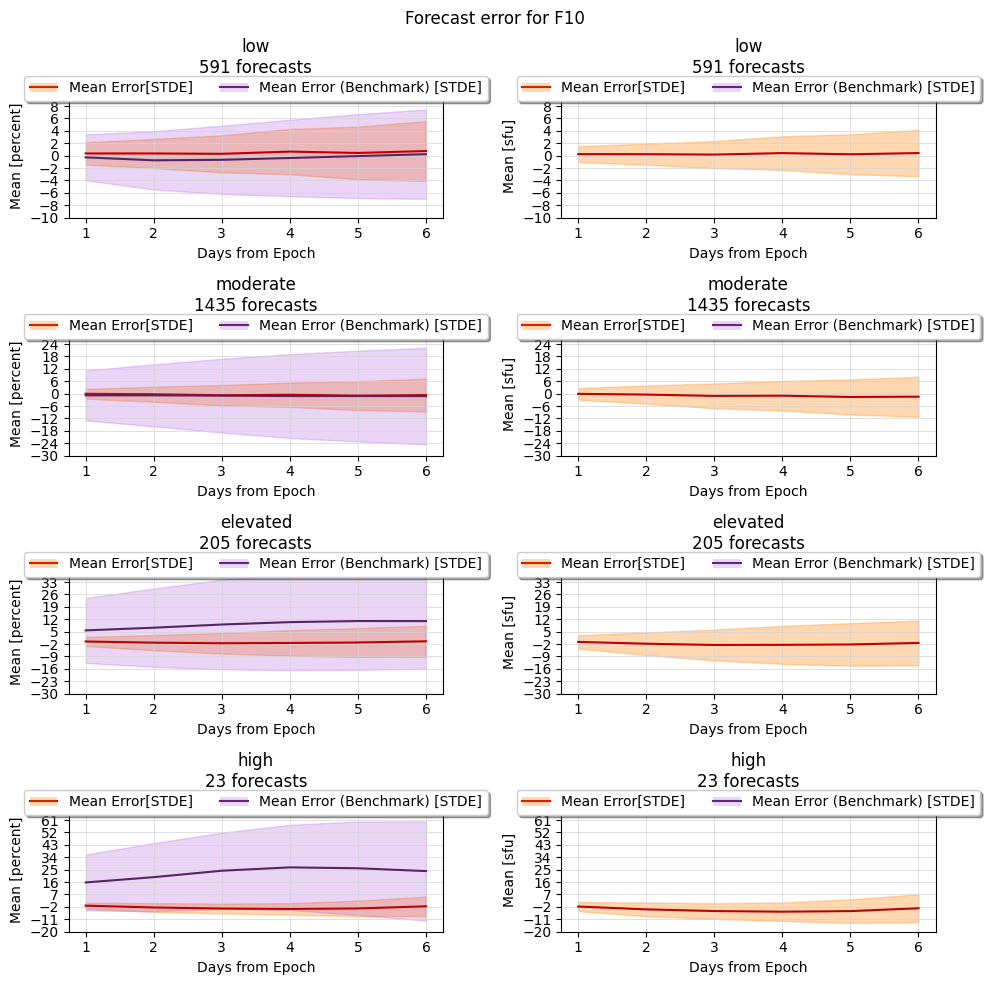

In [32]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'F10')

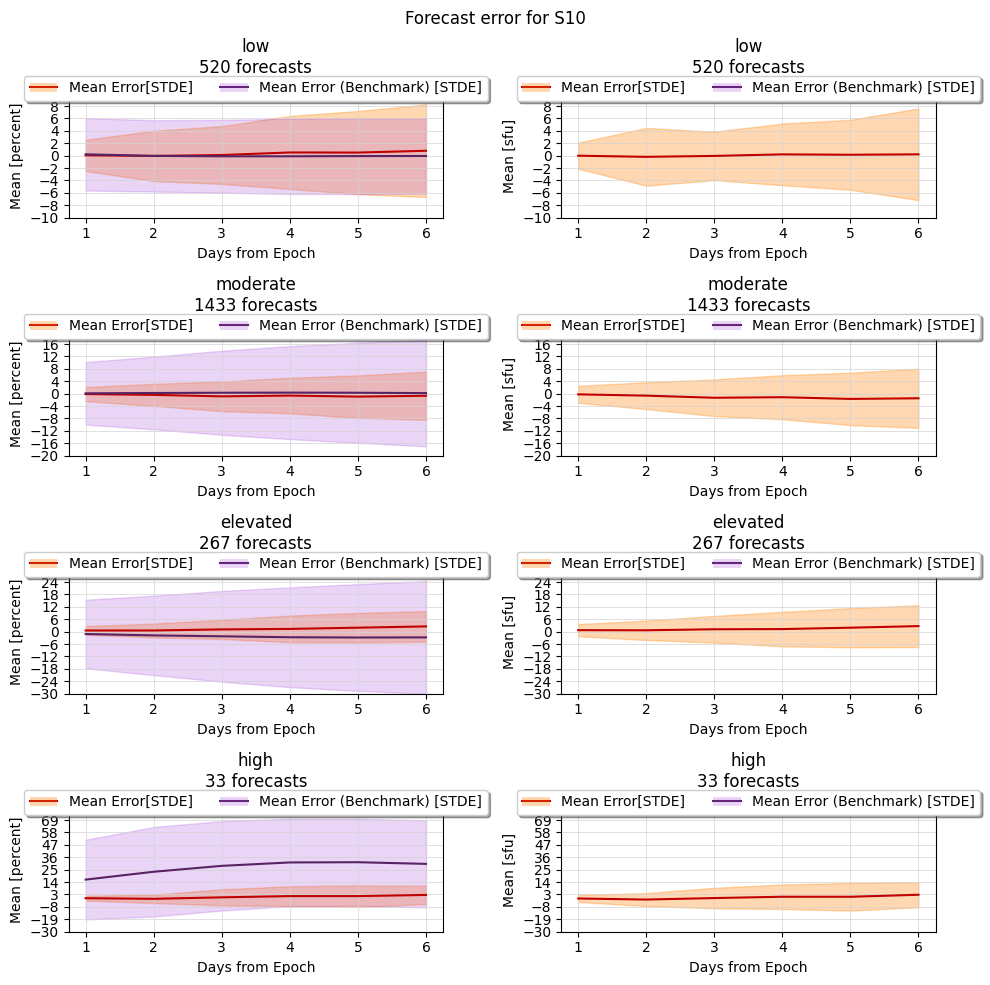

In [33]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'S10')

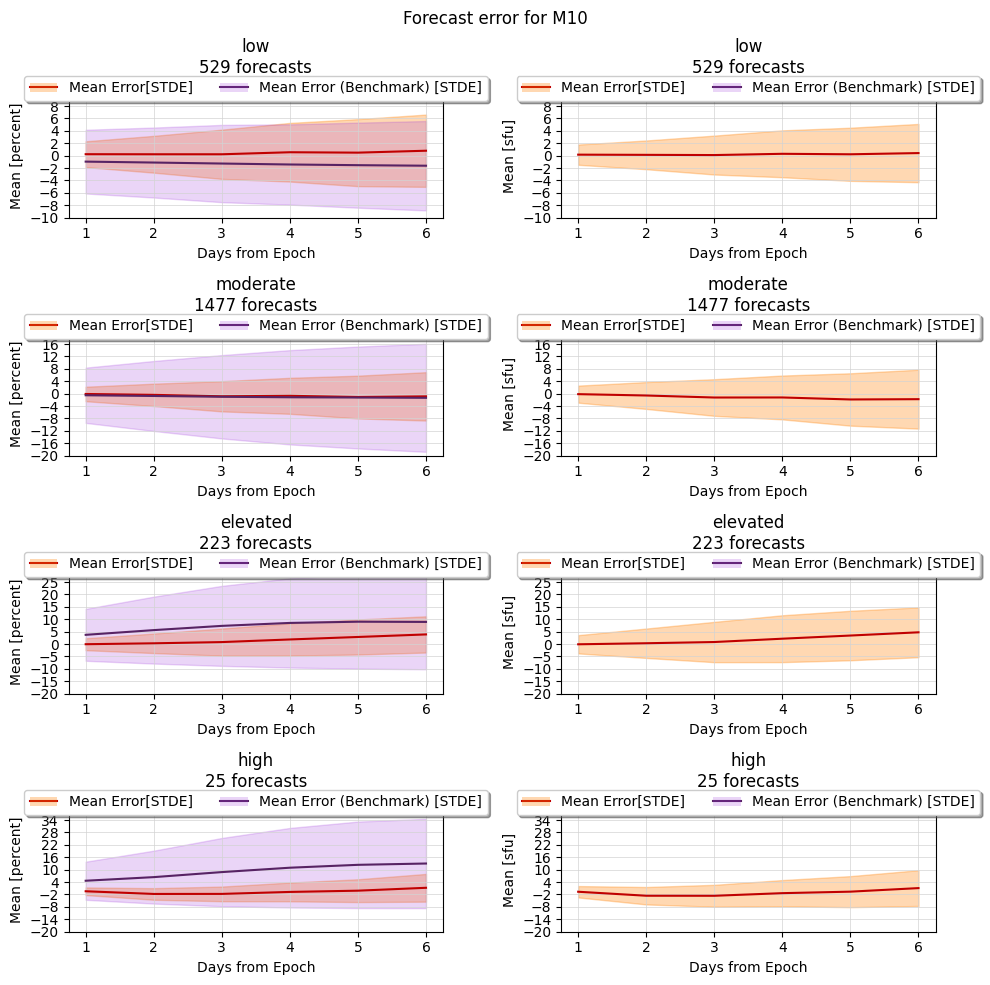

In [34]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'M10')

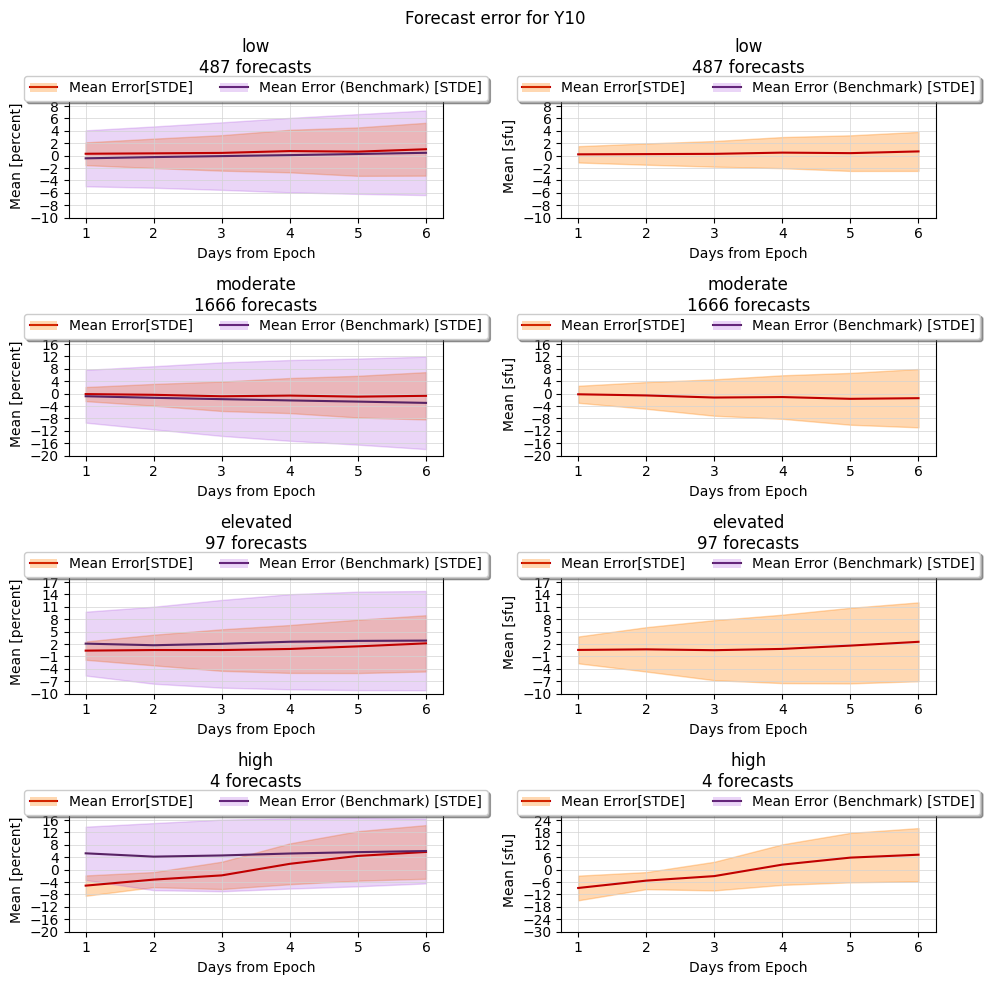

In [35]:
plot_solar_algorithm_performance_comparison(df_results, df_results_paper_formated, 'Y10')

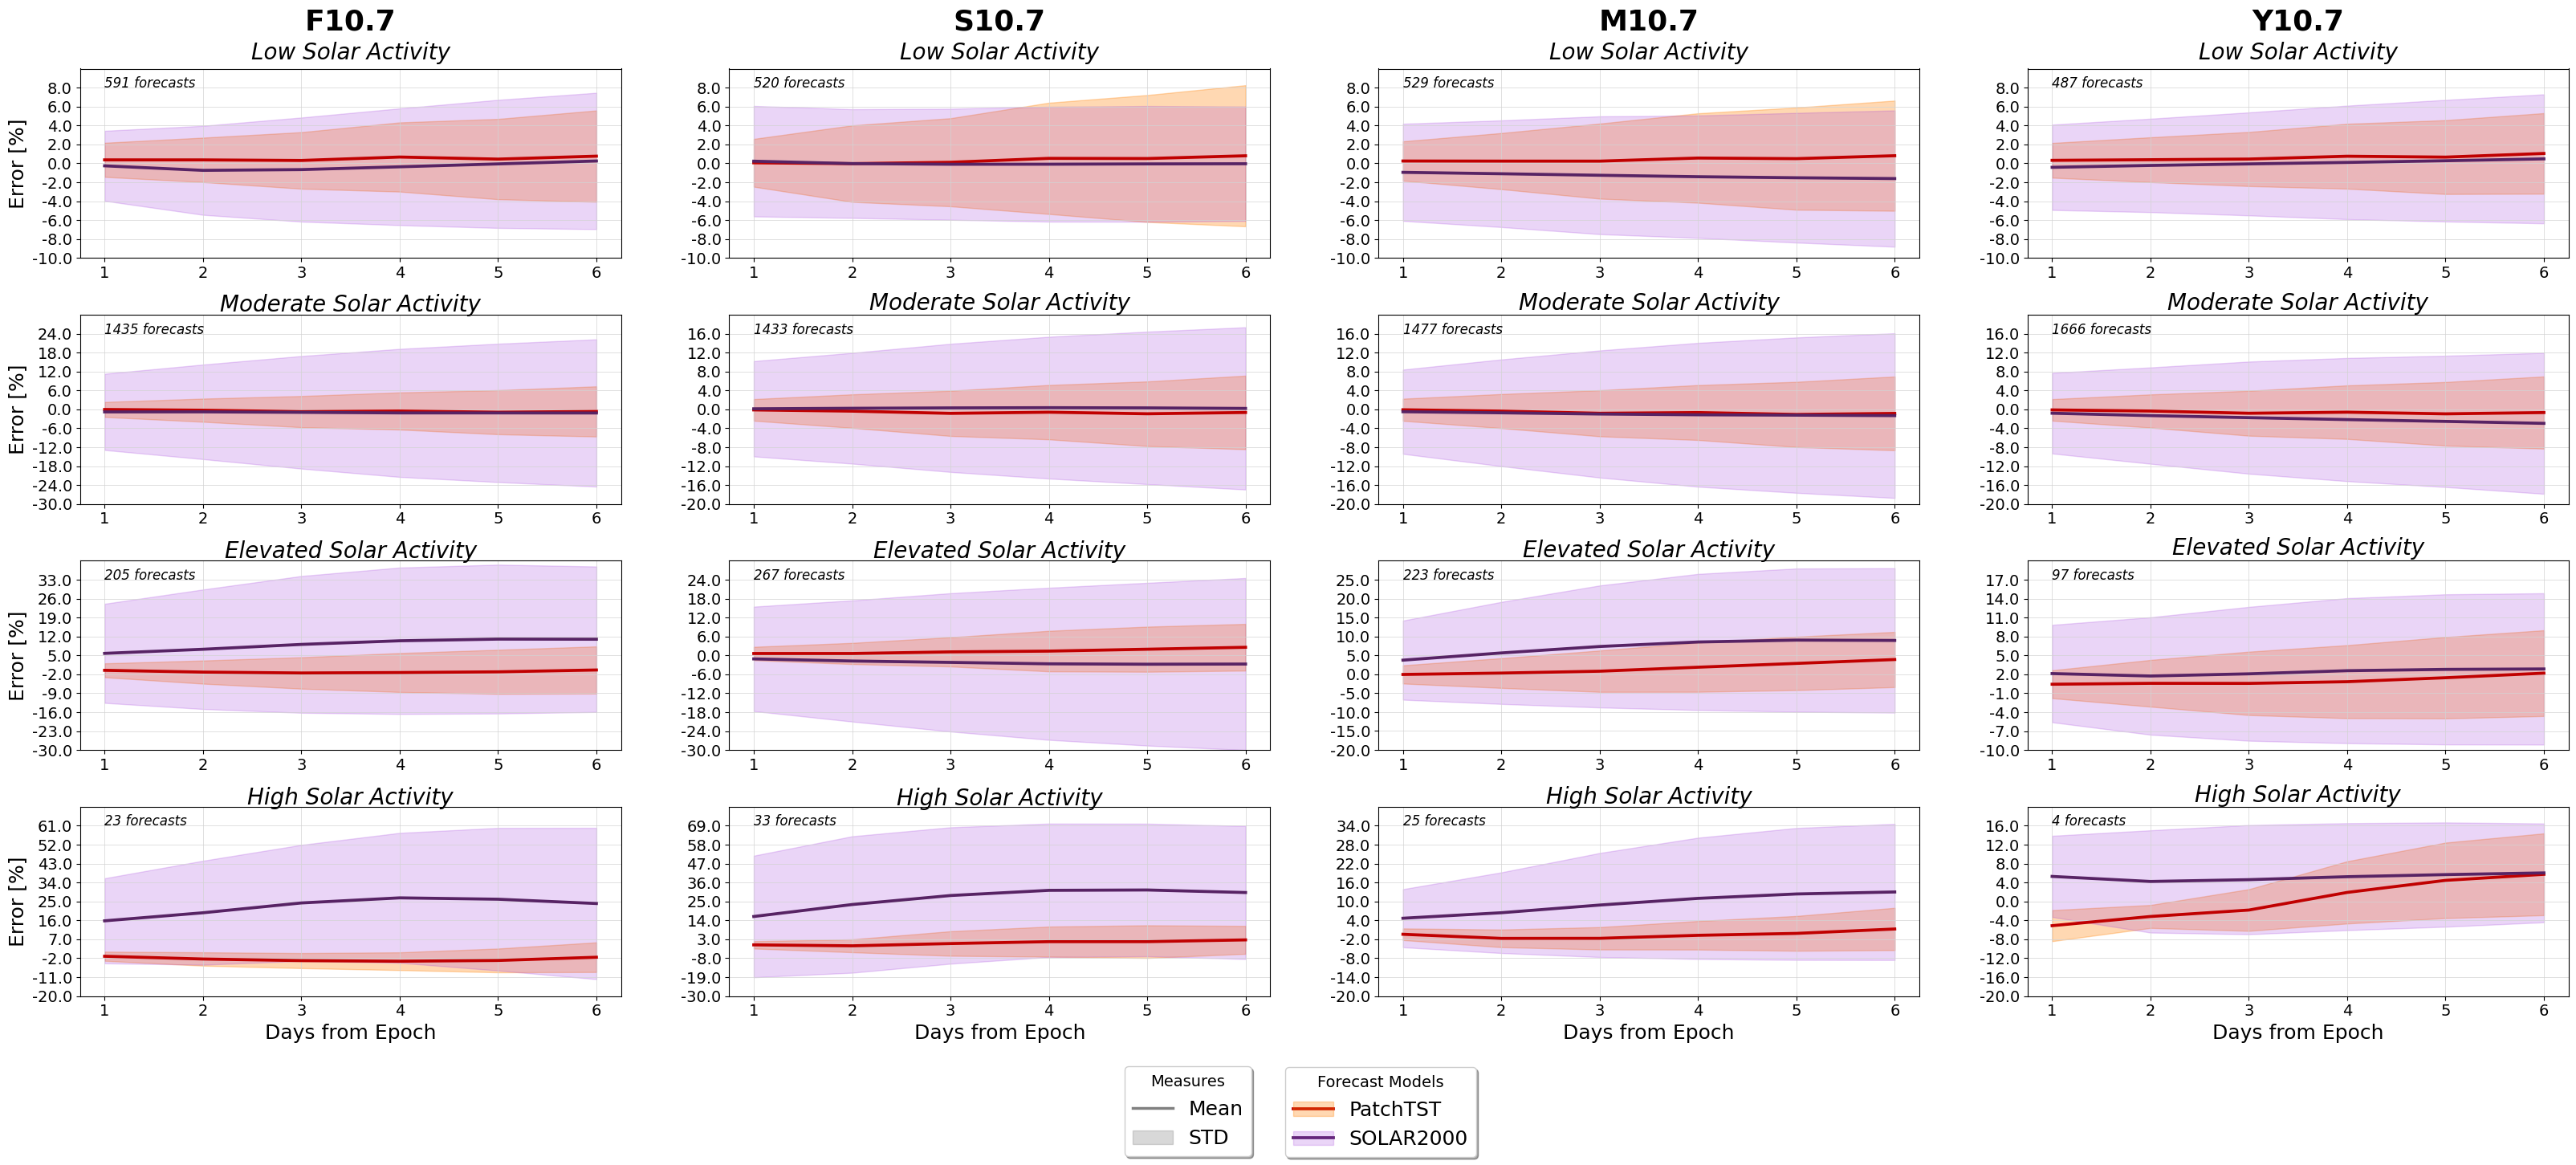

In [36]:
figure = plot_solar_algorithm_performance_all_indices(df_results, df_results_paper_formated, save_fig=True)

In [37]:
pivoted_df = df_results_joined.pivot_table(index=['variable', 'condition', 'statistic'], 
                            columns='horizon', 
                            values=['value_ours','value_paper'], 
                            aggfunc='first').reset_index()

# To order the columns in the way that we want
condition_order = ['low', 'moderate', 'elevated', 'high']
pivoted_df['condition'] = pd.Categorical(pivoted_df['condition'], categories=condition_order, ordered=True)

# Format columns names
pivoted_df.columns = pd.MultiIndex.from_tuples(
    list(pivoted_df.columns[:3]) + 
    [(value, f'{i} Days Horizon') for value in ['Value Ours', 'Value Benchmark'] for i in range(1,7)]
)

pivoted_df = pivoted_df.sort_values([('variable',''),('condition','')])
pivoted_df.head(1)

variable condition statistic     Value Ours                                \
                               1 Days Horizon 2 Days Horizon 3 Days Horizon   
4      F10       low      mean       0.253184       0.239555       0.176534   

                                               Value Benchmark                 \
  4 Days Horizon 5 Days Horizon 6 Days Horizon  1 Days Horizon 2 Days Horizon   
4       0.416489        0.22571       0.422187         -0.2685        -0.7472   

                                                               
  3 Days Horizon 4 Days Horizon 5 Days Horizon 6 Days Horizon  
4        -0.6672        -0.3721        -0.0674         0.2428

In [38]:
def highlight_max(row):
    # Empty color mask
    colors = [''] * len(row)
    columns = ['Value Ours', 'Value Benchmark']
    min_values = []
    
    for i in range(1,7):
        min_values.append(
            min(
                abs(row[('Value Ours', f'{i} Days Horizon')]), 
                abs(row[('Value Benchmark', f'{i} Days Horizon')])
            )
        )
    for i, value in enumerate(row[columns]):
        if np.abs(value) in min_values:
            colors[i+3] = 'background-color: grey'  # The 3 first columns are tags and no data
    return colors

# Compare and highlight # Get max of each element in both dataframes
styled_result = pivoted_df.style.apply(highlight_max, axis=1)

styled_result

In [39]:
improvement_df = pivoted_df.copy()
for i in range(1, 7):
    improvement_df[f'Improvement {i}'] = (improvement_df[('Value Ours', f'{i} Days Horizon')] - improvement_df[('Value Benchmark', f'{i} Days Horizon')]) / improvement_df[('Value Benchmark', f'{i} Days Horizon')] * 100

overall_mean_improvement = improvement_df.groupby('statistic')[[(f'Improvement {i}','')  for i in range(1, 7)]].mean().mean(axis=1)
variable_mean_improvement = improvement_df.groupby(['variable', 'statistic'])[[(f'Improvement {i}','') for i in range(1, 7)]].mean().mean(axis=1)
condition_mean_improvement = improvement_df.groupby(['condition', 'statistic'])[[(f'Improvement {i}','') for i in range(1, 7)]].mean().mean(axis=1)
var_cond_mean_improvement = improvement_df.groupby(['variable', 'condition', 'statistic'])[[(f'Improvement {i}','') for i in range(1, 7)]].mean().mean(axis=1)

variable_mean_improvement.keys()

MultiIndex([('F10', 'mean'),
            ('F10',  'std'),
            ('M10', 'mean'),
            ('M10',  'std'),
            ('S10', 'mean'),
            ('S10',  'std'),
            ('Y10', 'mean'),
            ('Y10',  'std')],
           names=['variable', 'statistic'])

In [40]:
aligned_series1 = pd.Series(overall_mean_improvement.values, 
                            index=pd.MultiIndex.from_tuples(
                                [('', 'overall', 'mean'), ('', 'overall', 'std')], 
                                names=['variable', 'condition', 'statistic']
                                )
                            )
aligned_series2 = pd.Series(variable_mean_improvement.values, 
                            index=pd.MultiIndex.from_tuples(
                                [(key[0],) + ('',) + (key[1],)  for key in variable_mean_improvement.keys()], 
                                names=['variable', 'condition', 'statistic']
                                )
                            )
aligned_series3 = pd.Series(condition_mean_improvement.values, 
                            index=pd.MultiIndex.from_tuples(
                                [('',) + key for key in condition_mean_improvement.keys()], 
                                names=['variable', 'condition', 'statistic']
                                )
                            )

# Concatenate the aligned series
performance_comparison_df = pd.DataFrame(pd.concat([aligned_series1, aligned_series2, aligned_series3, var_cond_mean_improvement], axis=0), columns=['Improvement'])
performance_comparison_df.dropna(inplace=True)

In [41]:
def color_gradient(val, df=performance_comparison_df):
    max_val = df['Improvement'].max()
    min_val = df['Improvement'].min()
    range_val = np.abs(max_val - min_val)
    normalized_val = np.abs(val - min_val) / range_val
    
    red = int(255 * normalized_val)
    green = int(255 * (1 - normalized_val))
    
    return f'background-color: rgb({red},{green},0); color: black'

styled_df = performance_comparison_df.style.applymap(color_gradient, subset=['Improvement'])
styled_df

In [42]:
create_latex_comparison_tables(df_results_joined, data_columns_fcst, horizon)

\begin{table}
\caption{Comparison of the results of the paper with the results of our model for the variable F10}
\label{tab:comparison_F10}
\begin{tabular}{|l||c||c||c||c||c||c|}
\toprule
condition & horizon & NN & benchmark \\
\midrule
low & 1 & \textbf{0.2531845} ± \textbf{1.2892721} & -0.2685 ± 3.6985 \\
low & 2 & \textbf{0.23955491} ± \textbf{1.6950568} & -0.7472 ± 4.7031 \\
low & 3 & \textbf{0.17653422} ± \textbf{2.183134} & -0.6672 ± 5.5001 \\
low & 4 & 0.41648918 ± \textbf{2.711614} & \textbf{-0.3721} ± 6.1683 \\
low & 5 & 0.2257096 ± \textbf{3.2175102} & \textbf{-0.0674} ± 6.7677 \\
low & 6 & 0.4221873 ± \textbf{3.7352185} & \textbf{0.2428} ± 7.205 \\
moderate & 1 & \textbf{-0.09100289} ± \textbf{2.8092394} & -0.8251 ± 12.0854 \\
moderate & 2 & \textbf{-0.43407473} ± \textbf{4.415401} & -0.8095 ± 14.9853 \\
moderate & 3 & -1.0789742 ± \textbf{5.9899874} & \textbf{-0.9639} ± 17.8425 \\
moderate & 4 & \textbf{-0.9738126} ± \textbf{7.1363397} & -1.145 ± 20.2973 \\
moderate & 5 & 